# An introduction to explainability in ML

In [176]:
! pip install torch --quiet

^C


In [ ]:
import sklearn
import pandas as pd
from pathlib import Path
import requests
from folktables import ACSDataSource, ACSEmployment
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, Sequential, Linear, ReLU
import matplotlib.pyplot as plt


# Exercise 1: Global explanations [25 mins]

We saw in the lecture that one way to explain a complex model is by approximating it with an inherently explainable model like decision trees.

In this exercise, you will build on the exercise from the last lecutre. Write a function that takes one of our three datasets (the custom synthetic dataset, COMPAS or ACS PUMS) and trains one of our two models (Logistic Regression and a Neural Network). The output of this function is the trained model.

Now write another function that takes a trained model and explains it using a decision tree. Which model is easier to explain with the decision tree?

In [ ]:
def load_custom_data():
    x, y = sklearn.datasets.make_classification(n_samples=200, n_features=10, n_informative=2, n_redundant=8, n_repeated=0, random_state=710)
    return x, y, [f"f{i}" for i in range(x.shape[1])]

CUSTOM_X, CUSTOM_Y, CUSTOM_FEATURES = load_custom_data()


In [ ]:
# COMPAS DATA
# get data from COMPAS
from pathlib import Path

import matplotlib.style
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import requests
import folktables
from folktables import ACSDataSource, ACSEmployment


# Selecting the font size here will affect all the figures in this notebook
# Alternatively, you can set the font size for axis labels of each figure separately
font = {'size': 16}
matplotlib.rc('font', **font)

matplotlib.style.use("fivethirtyeight")

# Based on: https://fairlens.readthedocs.io/en/latest/user_guide/compas.html
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
local_name = Path("compas-scores-two-years.csv")
if not local_name.is_file():
    response = requests.get(url)
    with open("compas-scores-two-years.csv", "w") as f:
        f.write(response.content.decode("utf-8"))
df = pd.read_csv(local_name)
df = df.sample(frac=1, random_state=1)

df = df[(df["days_b_screening_arrest"] <= 30)
        & (df["days_b_screening_arrest"] >= -30)
        & (df["is_recid"] != -1)
        & (df["c_charge_degree"] != 'O')
        & (df["score_text"] != 'N/A')].reset_index(drop=True)

import pandas as pd
COMAPS_X = df[["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree"]]
COMPAS_X = pd.get_dummies(COMAPS_X, columns=["c_charge_degree"], drop_first=True)
COMPAS_Y = df[["two_year_recid"]]
COMPAS_features = list(COMPAS_X.columns)

# ACS DATA
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AL"], download=True)  # Limiting to AL. You can try another state or all the states.
ACS_X, ACS_Y, _ = ACSEmployment.df_to_numpy(acs_data) 
ACS_features = ACSEmployment.features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

def train_model_on_data(x, y, model_type="neural_network"):
    if model_type == "logistic_regression":
        model = LogisticRegression(max_iter=1000)
    elif model_type == "neural_network":
        model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    else:
        raise ValueError("Unsupported model type. Choose 'logistic_regression' or 'neural_network'.")
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    print(f"Model Type: {model_type}, Score: {score}")
    return {"model": model, "x_test": x_test, "y_test": y_test, "x_train": x_train, "y_train": y_train, "y_pred_train": y_pred_train, "y_pred_test": y_pred_test} 

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

def evaluate_model(evaluation):
    model = evaluation["model"]
    x_test = evaluation["x_test"]
    y_test = evaluation["y_test"]
    y_pred = model.predict(x_test)
    explainer_model = DecisionTreeClassifier(max_depth=3)
    explainer_model.fit(x_test, y_pred)
    print(f"Accuracy overall: {explainer_model.score(x_test, y_test)}, Accuracy explainer: {explainer_model.score(x_test, y_pred)}")
    return explainer_model


Evaluating model on compas data with neural_network model.


c:\Users\frede\miniconda3\envs\RAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Type: neural_network, Score: 0.6898785425101215
Accuracy overall: 0.676923076923077, Accuracy explainer: 0.9303643724696357


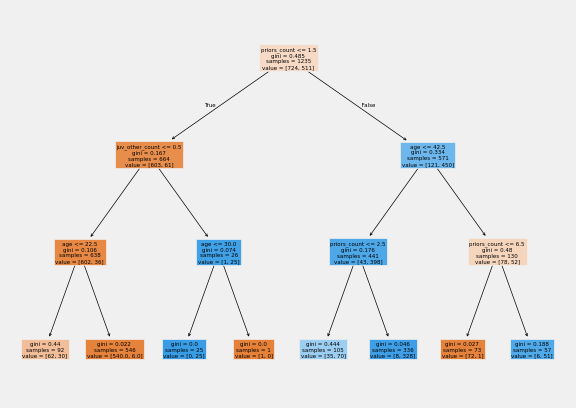

In [ ]:
# trying on custom data
def show_tree(model_type="logistic_regression", data_type="compas"):
    if data_type == "custom":
        x, y, features = CUSTOM_X, CUSTOM_Y, CUSTOM_FEATURES
    elif data_type == "compas":
        x, y, features = COMPAS_X, COMPAS_Y, COMPAS_features
    elif data_type == "acs":
        x, y, features = ACS_X, ACS_Y, ACS_features
    else:
        raise ValueError("Unsupported data type. Choose 'custom', 'compas', or 'acs'.")
    print(f"Evaluating model on {data_type} data with {model_type} model.")
    evaluation = train_model_on_data(x, y, model_type=model_type)
    model = evaluate_model(evaluation)
    tree.plot_tree(model, filled=True, feature_names=features)
    plt.show()
show_tree(model_type="neural_network", data_type="compas")

# Exercise 2: Evaluating explanations [25 mins]

In the lecture we saw that we can compute the quality of local explanations by dropping most or least important features and observing the impact on the model outputs. 

Given a dataset, e.g., PUMS and a model, e.g., a Neural Net, compare the following two explainability methods:
1. SHAP
2. A dummy explainability method that assigns an importance score to each feature by sampling from `np.random.rand()`

When dropping a feature, you can measure the difference in model output as $|f(\mathbf{x}) - f(\bar{\mathbf{x}})|$ where $\mathbf{x}$ is the original input and $\bar{\mathbf{x}}$ is the input with the feature removed.

How do the two explainers compare based on your performance metric?


In [ ]:
# get model
def get_model(model_type="logistic_regression", data_type="compas"):
    if data_type == "custom":
        x, y, features = CUSTOM_X, CUSTOM_Y, CUSTOM_FEATURES
    elif data_type == "compas":
        x, y, features = COMPAS_X, COMPAS_Y, COMPAS_features
    elif data_type == "acs":
        x, y, features = ACS_X, ACS_Y, ACS_features
    else:
        raise ValueError("Unsupported data type. Choose 'custom', 'compas', or 'acs'.")
    print(f"Getting model on {data_type} data with {model_type} model.")
    evaluation = train_model_on_data(x, y, model_type=model_type)
    return evaluation

In [ ]:
import shap

def evaluate_model_locally(evaluation, explainability_method, feature_names=None):
    model = evaluation["model"]
    x_test = evaluation["x_test"][:1]
    y_test = evaluation["y_test"][:1]
    if explainability_method == "shap":
        explainer = shap.KernelExplainer(model.predict_proba, x_test)
        shap_values = explainer.shap_values(x_test)[:, :, 1].mean(axis=0)
        # sort shap values descending (absolute value)
        sorted_indices = np.argsort(-np.abs(shap_values))  # negative for descending
        sorted_arr = shap_values[sorted_indices]

    elif explainability_method == "random":
        # assign random values to features
        random_values = np.random.rand(x_test.shape[1])
        sorted_indices = np.argsort(-np.abs(random_values))  # negative for descending
        sorted_arr = random_values[sorted_indices]
        
    else:
        raise ValueError("Unsupported explainability method. Choose 'shap' or 'random'.")
    if feature_names:
        # sort shap values with feature names descending (absolute value)
        shap_value_features = [feature_names[i] for i in sorted_indices]
        results = [(shap_value_features[i], sorted_arr[i]) for i in range(len(sorted_arr))]
        # result = [(shap_value_features[i], shap_values[i][shap_values_sorted[i]]) for i in range(len(shap_values))]
        return results
    else:
        # sort shap values with feature names descending (absolute value)
        return sorted_arr
            


    

In [ ]:
from pprint import pprint
model = get_model(model_type="neural_network", data_type="compas")
important_features_shap = evaluate_model_locally(model, explainability_method="shap", feature_names=CUSTOM_FEATURES)
pprint(important_features_shap)

important_features_random = evaluate_model_locally(model, explainability_method="random", feature_names=CUSTOM_FEATURES)
pprint(important_features_random)



Getting model on compas data with neural_network model.


c:\Users\frede\miniconda3\envs\RAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Type: neural_network, Score: 0.6947368421052632


100%|██████████| 1/1 [00:00<?, ?it/s]

[('f0', np.float64(0.0)),
 ('f1', np.float64(0.0)),
 ('f2', np.float64(0.0)),
 ('f3', np.float64(0.0)),
 ('f4', np.float64(0.0)),
 ('f5', np.float64(0.0))]
[('f4', np.float64(0.855199433469658)),
 ('f2', np.float64(0.7658549970087022)),
 ('f0', np.float64(0.47243185451676706)),
 ('f1', np.float64(0.45595181768573)),
 ('f5', np.float64(0.42934824207165245)),
 ('f3', np.float64(0.14410779597807422))]


In [ ]:
# reinference on data without most important feature (set to 0)
def reinference_on_data(evaluation, feature_name):
    model = evaluation["model"]
    x_test = evaluation["x_test"]
    y_test = evaluation["y_test"]
    x_test_no_feature = x_test.copy()
    feature_index = CUSTOM_FEATURES.index(feature_name)

    x_test_no_feature[:, feature_index] = 0
    return model.score(x_test_no_feature, y_test)


print("Reinference on data without most important feature")
for feature, _ in important_features_shap:
    print(f"Feature: {feature}")
    model = reinference_on_data(model, feature)
    print("\n")

# Exercise 3: Training Neural Networks with Gradient Descent [20 mins]

In this exercise, you do not have to solve much. Your task is to familiarize yourself with the code for training a neural network in PyTorch.

Walk through the code and make sure you understand it well.

Then train the network on PUMS data.

Neural networks are trained using graient descent. We pass the data in batches. The code below sets up a Data Loader that can let you iterate over the data in batches.

In [177]:
batch_size = 16

def convert_x_y_to_tensors(x, y):
    # Takes numpy arrays and convert them to PyTorch tensors.
    # Torch expects data to be in torch.Tensor objects
    x = torch.from_numpy(x)
    x = x.to(dtype=torch.float) # Features are floats
    y = torch.from_numpy(y).long()
    return x, y

# TODO: Add code to split the data in train and test sets
dataset_type = "acs"  # Change this to "compas" or "custom" for different datasets
if dataset_type == "custom":
    X, Y, features = CUSTOM_X, CUSTOM_Y, CUSTOM_FEATURES
elif dataset_type == "compas":
    X, Y, features = COMPAS_X.to_numpy(), COMPAS_Y.to_numpy(), COMPAS_features
elif dataset_type == "acs":
    X, Y, features = ACS_X, ACS_Y, ACS_features
else:
    raise ValueError("Unsupported dataset type. Choose 'custom', 'compas', or 'acs'.")
print(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, y_train = convert_x_y_to_tensors(x_train, y_train)
x_test, y_test = convert_x_y_to_tensors(x_test, y_test)


# We only make the data loader for the train set
# Test and validation set (if available) are small so we can run the model in a full batch setting
# You can similarly convert them to data loaders if the datasets are too large
train_loader = DataLoader(
    TensorDataset(x_train, y_train), 
    batch_size=batch_size, 
    shuffle=True,             # Shuffle at every epoch
)

for batch in train_loader:
    x_batch, y_batch = batch  # Unpack the batch
    print(f"Batch shape is x: {x_batch.shape} -- y: {y_batch.shape}")

[[19. 18.  5. ...  2.  2.  1.]
 [18. 18.  5. ...  2.  2.  2.]
 [53. 17.  5. ...  1.  1.  1.]
 ...
 [10.  6.  5. ...  2.  1.  1.]
 [ 4.  1.  5. ...  0.  1.  1.]
 [62. 16.  3. ...  2.  1.  1.]]
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Ba

Set up the model

In [ ]:
# All neural networks should inherit from nn.Module which implements some basic methods
class MyFirstNN(Module):
    def __init__(self, n_features, n_classes, hidden_units):     # Operations to carry out when we initialize the model
        super(MyFirstNN, self).__init__()                        # Call the __init__ of the super, or parent, class
        # Let us construct the layers one by one
        layers = []
        n_in = n_features
        for n_out in hidden_units:
            layers.append(Linear(n_in, n_out))  # Recall that a layer is just a mapping from an input to the output
            layers.append(ReLU())
            n_in = n_out
        layers.append(Linear(n_in, n_classes))

        # Next, tell pytorch that the layers are applied in sequence
        self.layers = Sequential(*layers)  # The * operator just unpacks all the layers
        
    def forward(self, x):
        # You should define the behavior of your NN when applied to the data.
        # In this case, we simply apply the layers one after the other.
        # The outputs are the logits, that is, the real-values scores for each class.
        return self.layers(x)
    
    def predict(self, x):
        # This function gives the prediction label.
        with torch.no_grad():
            if isinstance(x, np.ndarray):  # PyTorch models always expect tensors.
                x = torch.FloatTensor(x)
            preds = self(x)  # Apply the model
            pred_class = preds.argmax(axis=1)  # We get the logits for each class, select the one with the highest score
        return pred_class

my_first_nn = MyFirstNN(n_features=x_train.shape[1], n_classes=2, hidden_units=[1024, 1024])
print(my_first_nn)

MyFirstNN(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)


Check the accuracy. Of course the model is untrained so will have low accuracy.

In [ ]:
def compute_accuracy(model, x, y):
    preds = model.predict(x)
    return (preds==y).sum() / preds.shape[0]

print(f"Train accuracy: {compute_accuracy(my_first_nn, x_train, y_train):0.2f}")

Train accuracy: 0.59


Set up an optimizer 

In [ ]:
learning_rate = 1e-2  # Try different values
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    my_first_nn.parameters(),  # The parameters that we should optimize
    lr=learning_rate
)

Train the model

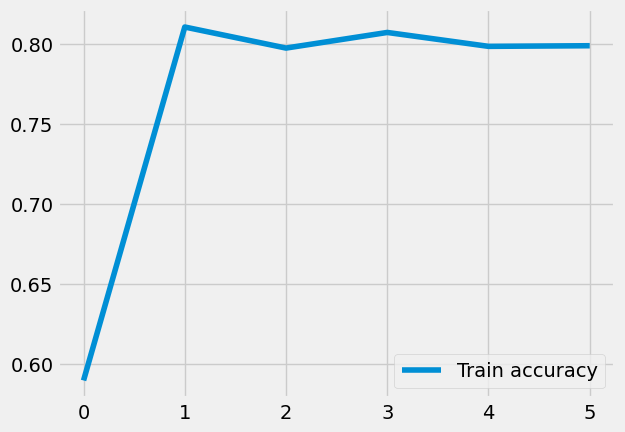

In [ ]:
%matplotlib inline

from IPython import display

num_epochs = 6

def train_model(num_epochs):
    train_accs = []
    my_first_nn.train()  # Put the model in the trianing mode
    
    plt.figure()
    ax = plt.gca()
    
    for epoch in range(num_epochs):
        # -----------------------------------------------
        # Print the performance at the end of each epoch
        # -----------------------------------------------
        my_first_nn.eval()  # Put the model in evaluation mode
        train_accs.append(compute_accuracy(my_first_nn, x_train, y_train))  # If the trainig data is large, you may want to do this iteratively with a data loader
        ax.clear()
        ax.plot(range(epoch+1), train_accs, label="Train accuracy")
        plt.legend()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        my_first_nn.train() # Put the model back in training model
        
        # --------------------------------------------
        # Train the model on all batches in the epoch
        # --------------------------------------------
        for batch in train_loader:
            x_batch, y_batch = batch  # Unpack the batch
    
            # Compute the loss
            pred = my_first_nn(x_batch)
            loss = loss_fn(pred, y_batch)
    
            # Take a gradient step
            loss.backward()        # Compute the gradient
            optimizer.step()       # Update the parameters
            optimizer.zero_grad()  # Zero out the gradients for the next iteration

train_model(num_epochs)

# Exercise 4: Counterfactual explanations [45 mins]

Write a function that given an input and the trained neural network model, generates a counterfactual explanation.

Recall that the counterfactual explanation ($\mathbf{x}_c$) is a modified version of the original input ($\mathbf{x}$) such that $f(\mathbf{x}) \neq f(\mathbf{x}_c)$.

You can generate the counterfactual explanations via gradient descent.

In [ ]:
learning_rate = 1e-2  # Try different values

x_input = x_test[0].unsqueeze(0)  # Add a batch dimension
# Set requires_grad to True


y_target = torch.Tensor([1]).long(9)
y_pred = my_first_nn.predict(x_input)
print(f"Input: {x_input}")
print(f"Target: {y_target}")
print(f"Prediction: {y_pred}")

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    [x_input],      # The parameters that we should optimize
    lr=learning_rate,
)

Input: tensor([[31., 13.,  1.,  1.,  2.,  0.,  4.,  3.,  4.,  1.,  2.,  2.,  2.,  2.,
          2.,  8.]])
Target: tensor([1.])
Prediction: tensor([0])


In [190]:
for i in range(100):
    # Compute the loss
    # pred = my_first_nn.predict(x_input)
    pred = my_first_nn(x_input.float())
    loss = loss_fn(pred, y_target)
    # Take a gradient step
    loss.backward()        # Compute the gradient
    optimizer.step()       # Update the parameters
    optimizer.zero_grad()  # Zero out the gradients for the next iteration
    print(f"Input: {x_input}")
    print(f"Target: {y_target}")
    print(f"Prediction: {my_first_nn.predict(x_input)}")
    print(f"Loss: {loss}")

    

RuntimeError: expected scalar type Long but found Float